In [2]:
#clean up for uninsured rate
library(dplyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(maptools)
library(rgdal)
options(jupyter.plot_mimetypes = 'image/png')

## Census tract data

To map data onto map at the census tract level, need to get California shapefile from census.gov. I chose cartographic boundary shapefiles for small scale mapping projects, at the 500k scale. The function readOGR() from the package rgdal can read shapefile into SpatialPolygonsDataFrame. GEOID has the unique ID for each county and will be used to join the ACS census data.

In [4]:
ca_shp = readOGR(dsn="cb_2014_06_tract_500k", layer ="cb_2014_06_tract_500k")

OGR data source with driver: ESRI Shapefile 
Source: "/Users/lingcheng/temp/sf-crime/cb_2014_06_tract_500k", layer: "cb_2014_06_tract_500k"
with 8043 features
It has 9 fields


Warning message:
In readOGR(dsn = "/Users/lingcheng/temp/sf-crime/cb_2014_06_tract_500k", : Z-dimension discarded

## Insurace coverage data from ACS(American community survey)

Insurace coverage data is from ACS 'ACS_14_5YR_B27001', 5-year estimate for 2014. I cleaned up the data in python and calculate the percentage of uninsured.

In [6]:
ca_data = read.csv('ACS_14_5YR_B27001/ACS_14_5YR_B27001_clean.csv')

In [7]:
head(ca_data)

,X,GEO.id,GEO.id2,GEO.display.label,HD01_VD01,insured,uninsured,percent
1,1,1400000US06075010100,6075010100,"Census Tract 101, San Francisco County, California",3827,3427,400,0.1045205
2,2,1400000US06075010200,6075010200,"Census Tract 102, San Francisco County, California",4220,3996,224,0.05308057
3,3,1400000US06075010300,6075010300,"Census Tract 103, San Francisco County, California",4346,4055,291,0.06695812
4,4,1400000US06075010400,6075010400,"Census Tract 104, San Francisco County, California",5265,4852,413,0.07844255
5,5,1400000US06075010500,6075010500,"Census Tract 105, San Francisco County, California",2606,2454,152,0.05832694
6,6,1400000US06075010600,6075010600,"Census Tract 106, San Francisco County, California",3651,3106,545,0.1492742


In [8]:
#convert data types
ca_data$GEO.id2 = as.character(ca_data$GEO.id2)
ca_data$GEO.display.label = as.character(ca_data$GEO.display.label)
ca_data$percent = ca_data$percent*100

In [9]:
#the leading zero is lost in csv; paste 0 to id
fun = function(x){paste0('0',x)}
ca_data$id = lapply(ca_data$GEO.id2, fun)
ca_data$id = as.character(ca_data$id)
str(ca_data)

'data.frame':	197 obs. of  9 variables:
 $ X                : int  1 2 3 4 5 6 7 8 9 10 ...
 $ GEO.id           : Factor w/ 197 levels "1400000US06075010100",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ GEO.id2          : chr  "6075010100" "6075010200" "6075010300" "6075010400" ...
 $ GEO.display.label: chr  "Census Tract 101, San Francisco County, California" "Census Tract 102, San Francisco County, California" "Census Tract 103, San Francisco County, California" "Census Tract 104, San Francisco County, California" ...
 $ HD01_VD01        : int  3827 4220 4346 5265 2606 3651 5311 4779 4740 5303 ...
 $ insured          : int  3427 3996 4055 4852 2454 3106 4613 4241 4579 4883 ...
 $ uninsured        : int  400 224 291 413 152 545 698 538 161 420 ...
 $ percent          : num  10.45 5.31 6.7 7.84 5.83 ...
 $ id               : chr  "06075010100" "06075010200" "06075010300" "06075010400" ...


## Merge census tract data with ACS insurance coverage data

To use census tract data, need to convert the SpatialPolygonsDataFrame back into data frame with fortiy(). Join census tract data with insurace coverage data based on id(unique id for each census tract). Filter the data to focus on 'San Francisco'. Plot with ggmap.

In [10]:
ca_tract<-fortify(ca_shp,region = "GEOID") 
str(ca_tract)

'data.frame':	330321 obs. of  7 variables:
 $ long : num  -122 -122 -122 -122 -122 ...
 $ lat  : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order: int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece: Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id   : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group: Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...


In [11]:
ca_tract2 = left_join(ca_tract,ca_data, by=c('id'))
str(ca_tract2)

'data.frame':	330321 obs. of  15 variables:
 $ long             : num  -122 -122 -122 -122 -122 ...
 $ lat              : num  37.9 37.9 37.9 37.9 37.9 ...
 $ order            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ hole             : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ piece            : Factor w/ 6 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ id               : chr  "06001400100" "06001400100" "06001400100" "06001400100" ...
 $ group            : Factor w/ 8112 levels "06001400100.1",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ X                : int  NA NA NA NA NA NA NA NA NA NA ...
 $ GEO.id           : Factor w/ 197 levels "1400000US06075010100",..: NA NA NA NA NA NA NA NA NA NA ...
 $ GEO.id2          : chr  NA NA NA NA ...
 $ GEO.display.label: chr  NA NA NA NA ...
 $ HD01_VD01        : int  NA NA NA NA NA NA NA NA NA NA ...
 $ insured          : int  NA NA NA NA NA NA NA NA NA NA ...
 $ uninsured        : int  NA NA NA NA NA NA NA NA NA NA ...
 $ percent          : num  NA 

In [12]:
ca_tract3 = ca_tract2[grep('San Francisco',ca_tract2$GEO.display.label),]
dim(ca_tract3)

[1] 2980   15

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=San+Francisco&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false


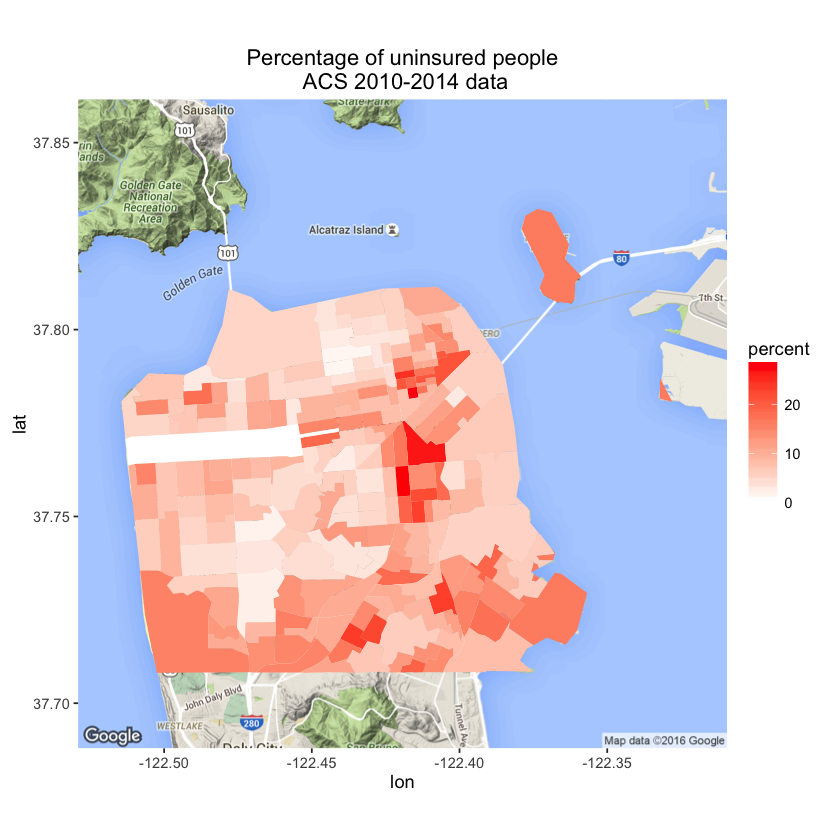

In [13]:
sf_basemap <-get_map('San Francisco', zoom=12) 
ggmap(sf_basemap) +
geom_polygon(data = ca_tract3 , aes(x=long, y=lat, group = group, fill=percent)) +
scale_fill_gradient(low="white",high="red") +
ggtitle('Percentage of uninsured people\n ACS 2010-2014 data')